In [92]:
import re 
import string 
import nltk 
import spacy 
import pandas as pd 
import numpy as np 
import math 
from tqdm import tqdm 
import bs4
import requests
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 
import networkx as nx
import matplotlib.pyplot as plt

In [93]:
nlp = spacy.load("en_core_web_sm")

  6%|▌         | 256/4318 [05:36<1:28:54,  1.31s/it]


In [94]:
text = "GDP in developing countries such as Vietnam will continue growing at a high rate." 

# create a spaCy object 
doc = nlp(text)

In [95]:
for tok in doc: 
  print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

GDP --> nsubj --> PROPN
in --> prep --> ADP
developing --> amod --> VERB
countries --> pobj --> NOUN
such --> amod --> ADJ
as --> prep --> ADP
Vietnam --> pobj --> PROPN
will --> aux --> AUX
continue --> ROOT --> VERB
growing --> xcomp --> VERB
at --> prep --> ADP
a --> det --> DET
high --> amod --> ADJ
rate --> pobj --> NOUN
. --> punct --> PUNCT


In [96]:
#define the pattern 
pattern = [{'POS':'NOUN'}, 
           {'LOWER': 'such'}, 
           {'LOWER': 'as'}, 
           {'POS': 'PROPN'} #proper noun
          ]

In [97]:
# Rule Based Infromation Extraction

In [98]:
# Matcher class object 
matcher = Matcher(nlp.vocab) 
matcher.add("matching_1",[pattern]) 

matches = matcher(doc) 
span = doc[matches[0][1]:matches[0][2]] 

print(span.text)

countries such as Vietnam


In [99]:
#Subtree Matching
text = "Tableau was recently acquired by Salesforce." 

# Plot the dependency graph 
doc = nlp(text) 
displacy.render(doc, style='dep',jupyter=True)

In [100]:
text = "Tableau was recently acquired by Salesforce." 
doc = nlp(text) 

for tok in doc: 
  print(tok.text,"-->",tok.dep_,"-->",tok.pos_)

Tableau --> nsubjpass --> PROPN
was --> auxpass --> AUX
recently --> advmod --> ADV
acquired --> ROOT --> VERB
by --> agent --> ADP
Salesforce --> pobj --> PROPN
. --> punct --> PUNCT


In [101]:
def subtree_matcher(doc):
  subjpass = 0

  for i,tok in enumerate(doc):
    # find dependency tag that contains the text "subjpass"    
    if tok.dep_.find("subjpass") == True:
      subjpass = 1

  x = ''
  y = ''

  # if subjpass == 1 then sentence is passive
  if subjpass == 1:
    for i,tok in enumerate(doc):
      if tok.dep_.find("subjpass") == True:
        y = tok.text

      if tok.dep_.endswith("obj") == True:
        x = tok.text
  
  # if subjpass == 0 then sentence is not passive
  else:
    for i,tok in enumerate(doc):
      if tok.dep_.endswith("subj") == True:
        x = tok.text

      if tok.dep_.endswith("obj") == True:
        y = tok.text

  return x,y

In [102]:
subtree_matcher(doc)

('Salesforce', 'Tableau')

In [103]:
text_2 = "Careem, a ride hailing major in middle east, was acquired by Uber." 

doc_2 = nlp(text_2) 
subtree_matcher(doc_2)

('Uber', 'Careem')

In [104]:
text_3 = "Salesforce recently acquired Tableau." 
doc_3 = nlp(text_3) 
subtree_matcher(doc_3)

('Salesforce', 'Tableau')

In [105]:
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [106]:
candidate_sentences['sentence'].sample(5)

312     animated cartoons came principally as short su...
1126          xavier's college in mumbai but dropped out.
1973    this can draw fan acclaim and obsession more r...
3606                 this technique was patented in 1991.
3036    it would eventually see many theatrical and ho...
Name: sentence, dtype: object

In [107]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [108]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [109]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:24<00:00, 177.82it/s]


In [110]:
entity_pairs[10:20]

[['we', 'tests'],
 ['', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'eberhardt portrays'],
 ['singer', 'men']]

In [111]:
'''def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1
  print(matches[k][1],matches[k][2])
  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)
  '''

'def get_relation(sent):\n\n  doc = nlp(sent)\n\n  # Matcher class object \n  matcher = Matcher(nlp.vocab)\n\n  #define the pattern \n  pattern = [{\'DEP\':\'ROOT\'}, \n            {\'DEP\':\'prep\',\'OP\':"?"},\n            {\'DEP\':\'agent\',\'OP\':"?"},  \n            {\'POS\':\'ADJ\',\'OP\':"?"}] \n\n  matcher.add("matching_1", [pattern]) \n\n  matches = matcher(doc)\n  k = len(matches) - 1\n  print(matches[k][1],matches[k][2])\n  span = doc[matches[k][1]:matches[k][2]] \n\n  return(span.text)\n  '

In [112]:
def get_relation(sent):
  doc = nlp(sent)
  #We initialise matcher with the vocab
  matcher = Matcher(nlp.vocab)
  #Defining the pattern
  pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':'?'},{'DEP':'agent','OP':'?'},{'DEP':'ADJ','OP':'?'}]
  #Adding the pattern to the matcher
  matcher.add("matcher_1",[pattern])
  #Applying the matcher to the doc
  matches = matcher(doc)

  #The matcher returns a list of (match_id, start, end). The start to end in our doc contains the relation. We capture that relation in a variable called span
  try:
      span = doc[matches[0][1]:matches[0][2]]
  except:
      return None
  return span.text



  

In [113]:
get_relation("John completed the task")

'completed'

In [114]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:27<00:00, 157.78it/s]


In [115]:
pd.Series(relations).value_counts()[:50]

is            414
was           347
released      166
are           102
were           88
include        80
produced       49
made           45
's             42
used           41
composed       40
became         40
have           33
has            32
began          32
become         32
included       31
received       28
been           27
had            26
directed       26
written        26
considered     25
be             23
set            22
shot           22
cast           22
called         20
introduced     20
went           19
stars          19
opened         18
announced      18
scheduled      17
known          17
started        17
hired          16
developed      16
includes       15
starred        15
wrote          15
shown          14
sold           13
provided       12
wanted         12
done           12
based          12
won            12
ended          12
came           11
dtype: int64

In [116]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [117]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

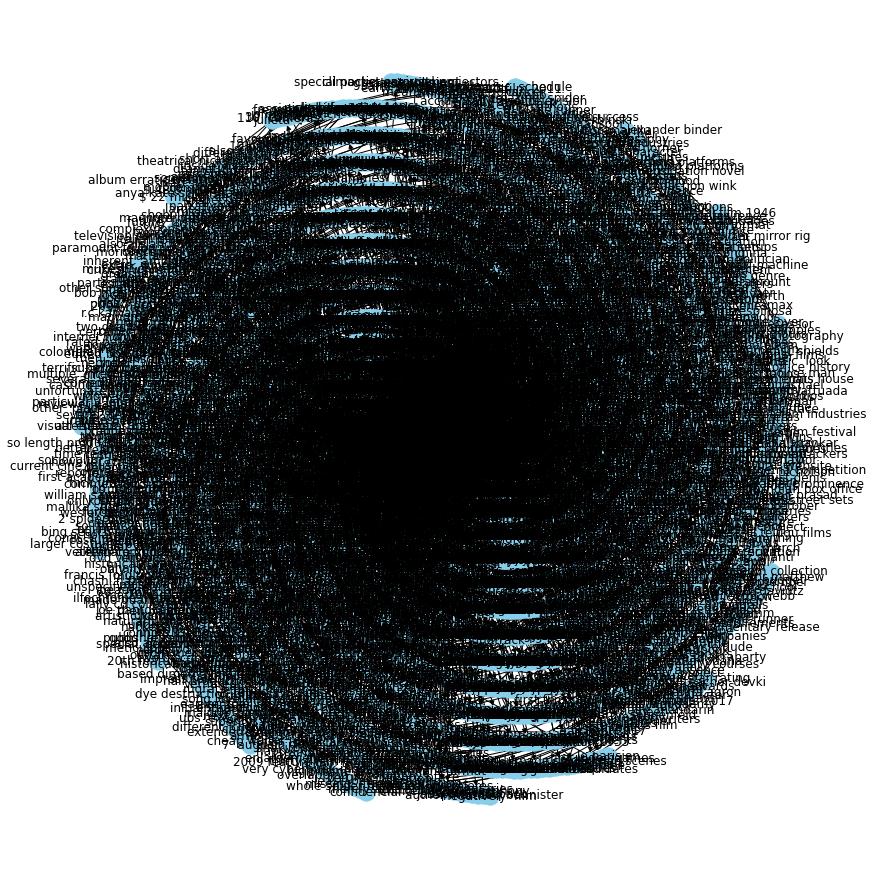

In [120]:
plt.figure(figsize=(12,12))

pos = nx.spiral_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [121]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="produced"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

NetworkXError: random_state_index is incorrect

<Figure size 864x864 with 0 Axes>

In [ ]:
Data = ''' The pizza is made by Moby '''

In [ ]:
Data

In [ ]:
entity_pairs = []
Data = Data.split(".")
for i in tqdm(Data):
  entity_pairs.append(get_entities(i))

In [ ]:
entity_pairs

In [ ]:
relations = [get_relation(i) for i in tqdm(Data)]

In [ ]:
relations

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()